# Training

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
import shap

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc, accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 500)

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# PCA

In [8]:
img_df = pd.read_csv("/Users/johngalvin/Downloads/AD1ChallengeImagingFiles/baseline_data.csv")
img_ptids = img_df["Subject"]
X = img_df.iloc[:,:-13] # Keep just image features

Columns (2162) have mixed types.Specify dtype option on import or set low_memory=False.


In [9]:
# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# Cov matrix
cov = (X_scaled.T @ X_scaled) / (X_scaled.shape[0] - 1)

In [11]:
# Eigendecomposition
eig_values, eig_vectors = np.linalg.eig(cov)

In [12]:
# Figure out which components to select
idx = np.argsort(eig_values, axis=0)[::-1]
sorted_eig_vectors = eig_vectors[:, idx]

Casting complex values to real discards the imaginary part


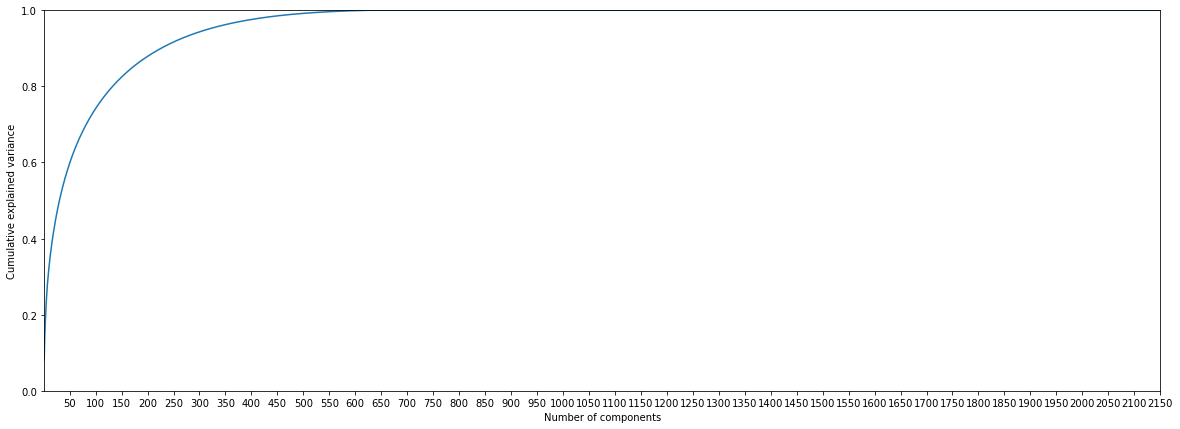

In [13]:
# Determine how many components to keep
cumsum = np.cumsum(eig_values[idx]) / np.sum(eig_values[idx])
xint = range(1, len(cumsum) + 1)
plt.figure(figsize=(20, 7))
plt.plot(xint, cumsum)

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.xticks(np.arange(0, 2151, 50))
plt.xlim(1, len(cumsum))
plt.ylim(0, 1)  # Set y-axis limits between 0 and 1 if necessary

plt.show()

In [14]:
# Determine names of components
num_components_to_keep = 150
selected_eigenvectors = sorted_eig_vectors[:, :num_components_to_keep]

# Get the column names corresponding to the selected eigenvectors
selected_component_names = img_df.columns[:-13][np.argsort(np.abs(selected_eigenvectors.sum(axis=1)))[::-1][:num_components_to_keep]]
selected_component_names = selected_component_names.tolist()

In [15]:
# Reconstruct df
img_df = img_df[selected_component_names]
img_df = pd.concat([img_ptids, img_df], axis=1)
img_df.reset_index(drop=True, inplace=True)
img_df.rename({"Subject": "PTID"}, axis=1, inplace=True)

# Merge MRI and Clinical/Genetic Data

In [16]:
# Read in med/famhist
mf_hist = pd.read_csv('../data/clinical_training_data.csv')

# Handle Nan
mf_hist["APOE4"] = mf_hist["APOE4"].fillna(0)

# Join with img_df
df = pd.merge(mf_hist, img_df, on="PTID", how="inner")

# For converting categorical variables to ints
label_encoder = LabelEncoder()

# Split features / target
X = df.drop(columns=['PTID',
                     'AD_dx_in_5_yrs', 
                     'AD_dx_in_any_time', 
                     'AD_dx_in_15_yrs',
                     'AD_dx_in_10_yrs', 
                     'AD_dx_in_4_yrs', 
                     'AD_dx_in_3_yrs',
                     'AD_dx_in_2_yrs', 
                     'AD_dx_in_1_yr'])
y = df['AD_dx_in_5_yrs']

# Encode features
X["Diagnosis_at_Baseline"] = label_encoder.fit_transform(X["Diagnosis_at_Baseline"])
#joblib.dump(label_encoder, "dx_encoder.gz")
X["Gender"] = label_encoder.fit_transform(X["Gender"])
#joblib.dump(label_encoder, "gender_encoder.gz")
X["Ethnicity"] = label_encoder.fit_transform(X["Ethnicity"])
#joblib.dump(label_encoder, "eth_encoder.gz")
X["Race"] = label_encoder.fit_transform(X["Race"])
#joblib.dump(label_encoder, "race_encoder.gz")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [17]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#joblib.dump(scaler, "scaler.gz")

In [18]:
# Reorder labels (order changed when forming unscaled_mri_df)
y_train_final = []
for val in X_train.index.values:
    y_train_final.append(df.loc[df.index == val, "AD_dx_in_5_yrs"].values[0])
y_train_final = np.array(y_train_final)

y_val_final = []
for val in X_val.index.values:
    y_val_final.append(df.loc[df.index == val, "AD_dx_in_5_yrs"].values[0])
y_val_final = np.array(y_val_final)

y_test_final = []
for val in X_test.index.values:
    y_test_final.append(df.loc[df.index == val, "AD_dx_in_5_yrs"].values[0])
y_test_final = np.array(y_test_final)

In [19]:
# Oversample
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train_final)

# NN, Multimodal

In [20]:
IN_FEATURES = X_train_scaled[0].shape[0]

In [21]:
def create_model(dropout=0.3, learning_rate=0.001, l1_penalty=0.001, l2_penalty=0.001):
    """Builds classification model"""
    
    model = tf.keras.Sequential()
    inputs = tf.keras.layers.Input(shape=(IN_FEATURES,), name="input_layer") # (Batch, num_features)
    
    hidden_1 = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1_penalty, l2=l2_penalty), name="hidden_1")(inputs)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)
    hidden_2 = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1_penalty, l2=l2_penalty), name="hidden_2")(hidden_1)
    hidden_2 = tf.keras.layers.Dropout(dropout)(hidden_2)
    
    classification = tf.keras.layers.Dense(1, activation="sigmoid", name="classification_layer")(hidden_1)
    classification_model = tf.keras.Model(inputs=[inputs], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                                 metrics="accuracy")

    return classification_model

In [22]:
model = create_model()

2023-11-21 12:40:08.927546: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-11-21 12:40:08.927608: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-21 12:40:08.927618: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-21 12:40:08.927705: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-21 12:40:08.927740: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
es = EarlyStopping(monitor="val_loss", 
                   patience=4,
                   verbose=0,
                   restore_best_weights=True)

tf.config.run_functions_eagerly(True)
history = model.fit(X_train_resampled,
                    y_train_resampled,
                    validation_data=[X_val_scaled, y_val_final],
                    batch_size=16,
                    epochs=20)

Epoch 1/20


Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
"`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?


27/27 [==============================] - 1s 27ms/step - loss: 3.1656 - accuracy: 0.6315 - val_loss: 2.9928 - val_accuracy: 0.6625
Epoch 2/20
27/27 [==============================] - 1s 25ms/step - loss: 2.6362 - accuracy: 0.8662 - val_loss: 2.7045 - val_accuracy: 0.7125
Epoch 3/20
27/27 [==============================] - 1s 24ms/step - loss: 2.2828 - accuracy: 0.9202 - val_loss: 2.4909 - val_accuracy: 0.7000
Epoch 4/20
27/27 [==============================] - 1s 24ms/step - loss: 2.0093 - accuracy: 0.9695 - val_loss: 2.2584 - val_accuracy: 0.7000
Epoch 5/20
27/27 [==============================] - 1s 24ms/step - loss: 1.7679 - accuracy: 0.9695 - val_loss: 2.0808 - val_accuracy: 0.7250
Epoch 6/20
27/27 [==============================] - 1s 24ms/step - loss: 1.5526 - accuracy: 0.9930 - val_loss: 1.9158 - val_accuracy: 0.7125
Epoch 7/20
27/27 [==============================] - 1s 24ms/step - loss: 1.3801 - accuracy: 0.9883 - val_loss: 1.7685 - val_accuracy: 0.7250
Epoch 8/20
27/27 [======

In [24]:
print ("If simply guessing all 0, can get this train accuracy:", 1 - y_train_resampled.sum() / y_train_resampled.shape[0])
print ("If simply guessing all 0, can get this val accuracy:", 1 - y_val_final.sum() / y_val_final.shape[0])
print ("If simply guessing all 0, can get this test accuracy:", 1 - y_test_final.sum() / y_test_final.shape[0])

If simply guessing all 0, can get this train accuracy: 0.5
If simply guessing all 0, can get this val accuracy: 0.6125
If simply guessing all 0, can get this test accuracy: 0.6599999999999999


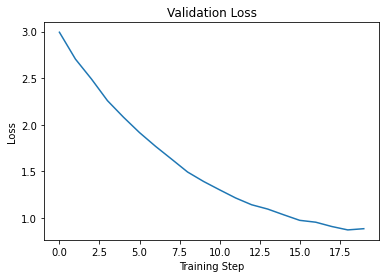

In [25]:
# Visualize loss curve

losses = history.history["val_loss"]
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.show()

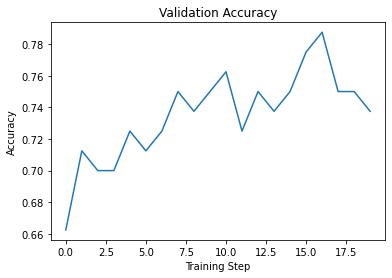

In [26]:
# Visualize accuracy curve

losses = history.history["val_accuracy"]
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.show()

In [27]:
preds = model.predict(X_test_scaled)
preds = [1 if preds[i][0] >=0.5 else 0 for i in range(len(preds))]

tp = 0
fp = 0
fn = 0

for i in range(len(preds)):
    if preds[i] == 1 and y_test_final[i] == 1:
        tp += 1
    elif preds[i] == 1 and y_test_final[i] == 0:
        fp += 1
    elif preds[i] == 0 and y_test_final[i] == 1:
        fn += 1

prec = tp / (tp + fp)
rec = tp / (tp + fn)
f1 = (2 * prec * rec) / (prec + rec)

print (f'Precision: {prec}')
print (f'Recall: {rec}')
print (f'F1: {f1}')

4/4 [==============================] - 0s 7ms/step
Precision: 0.5428571428571428
Recall: 0.5588235294117647
F1: 0.5507246376811593


In [28]:
print (classification_report(y_test_final, preds))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76        66
           1       0.54      0.56      0.55        34

    accuracy                           0.69       100
   macro avg       0.66      0.66      0.66       100
weighted avg       0.69      0.69      0.69       100



## K-fold Cross-Validation

In [23]:
# Initialize kf
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Train
acc_per_fold = []
loss_per_fold = []

fold_no = 1
for train, val in kf.split(X_train_resampled, y_train_resampled):
    model = create_model()
    
    history = model.fit(X_train_resampled[train], 
                        y_train_resampled[train], 
                        epochs=15, 
                        batch_size=32, 
                        validation_data=(X_train_resampled[val], y_train_resampled[val]))
    
    # Generate generalization metrics
    scores = model.evaluate(X_test_scaled, y_test_final, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no += 1

# Print average metrics
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/15
 4/11 [=========>....................] - ETA: 0s - loss: 3.3113 - accuracy: 0.5938

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/johngalvin/miniforge3/lib/python3.9/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


11/11 [==============================] - 0s 34ms/step - loss: 3.2768 - accuracy: 0.5882 - val_loss: 3.0890 - val_accuracy: 0.6512
Epoch 2/15
11/11 [==============================] - 0s 24ms/step - loss: 2.9010 - accuracy: 0.8000 - val_loss: 2.8603 - val_accuracy: 0.7907
Epoch 3/15
11/11 [==============================] - 0s 25ms/step - loss: 2.6704 - accuracy: 0.8471 - val_loss: 2.6658 - val_accuracy: 0.8721
Epoch 4/15
11/11 [==============================] - 0s 24ms/step - loss: 2.4659 - accuracy: 0.8971 - val_loss: 2.4890 - val_accuracy: 0.8837
Epoch 5/15
11/11 [==============================] - 0s 24ms/step - loss: 2.2759 - accuracy: 0.9294 - val_loss: 2.3347 - val_accuracy: 0.9070
Epoch 6/15
11/11 [==============================] - 0s 24ms/step - loss: 2.1088 - accuracy: 0.9353 - val_loss: 2.1882 - val_accuracy: 0.9070
Epoch 7/15
11/11 [==============================] - 0s 25ms/step - loss: 1.9533 - accuracy: 0.9706 - val_loss: 2.0540 - val_accuracy: 0.8953
Epoch 8/15
11/11 [======

In [24]:
joblib.dump(model, 'model.pkl')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dropout
.........vars
......input_layer
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-10-23 10:06:53         2624
metadata.json                                  2023-10-23 10:06:53           64
variables.h5                                   2023-10-23 10:06:53       515504


['model.pkl']

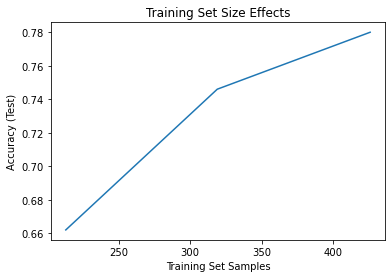

In [29]:
# Training Size Effects

sizes = [213, 319, 426]
acc = [0.662, 0.746, 0.78]

plt.plot(sizes, acc)
plt.xlabel("Training Set Samples")
plt.ylabel("Accuracy (Test)")
plt.title("Training Set Size Effects");

In [39]:
# Explain predictions - had to retrain model because couldn't load existing since
# existing model was trained on different version of tf and saved with joblib

masker = shap.maskers.Independent(data=X_train_resampled)

# Create the SHAP explainer
explainer = shap.Explainer(model, masker=masker)

In [35]:
shap_values = explainer.shap_values(X_train_resampled)

PermutationExplainer explainer: 427it [01:03,  5.66it/s]                                                                          


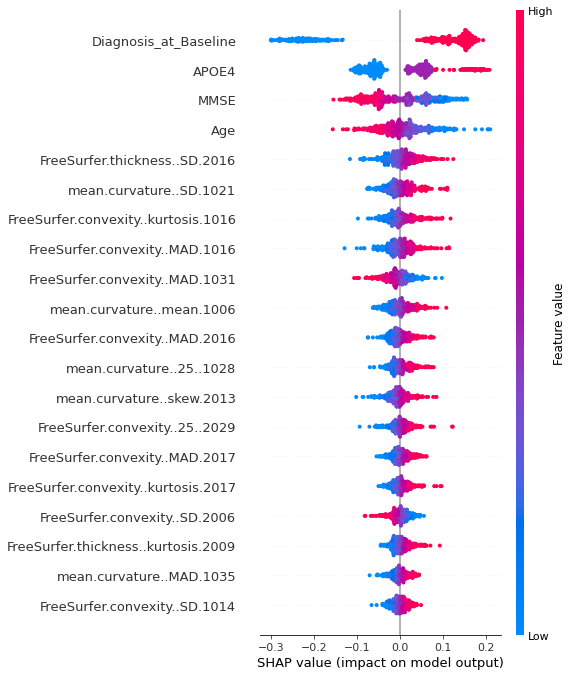

In [38]:
shap.summary_plot(shap_values, X_train_resampled, feature_names=X.columns.to_list())

# NN, Image-only

Run all PCA cells, then these

In [10]:
# Read in med/famhist
mf_hist = pd.read_csv('../data/clinical_training_data.csv')

# Join with img_df
df = pd.merge(mf_hist, img_df, on="PTID", how="inner")

# For converting categorical variables to ints
label_encoder = LabelEncoder()
scaler = MinMaxScaler()

# Split features / target
X = df.drop(columns=['PTID',
                     'Diagnosis_at_Baseline',
                     'Age',
                     'Gender',
                     'Years_of_Education',
                     'Ethnicity',
                     'Race',
                     'APOE4',
                     'MMSE',
                     'AD_dx_in_5_yrs', 
                     'AD_dx_in_any_time', 
                     'AD_dx_in_15_yrs',
                     'AD_dx_in_10_yrs', 
                     'AD_dx_in_4_yrs', 
                     'AD_dx_in_3_yrs',
                     'AD_dx_in_2_yrs', 
                     'AD_dx_in_1_yr'])
y = df['AD_dx_in_10_yrs']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Reorder labels (order changed when forming unscaled_mri_df)
y_train_final = []
for val in X_train.index.values:
    y_train_final.append(df.loc[df.index == val, "AD_dx_in_10_yrs"].values[0])
y_train_final = np.array(y_train_final)

y_val_final = []
for val in X_val.index.values:
    y_val_final.append(df.loc[df.index == val, "AD_dx_in_10_yrs"].values[0])
y_val_final = np.array(y_val_final)

y_test_final = []
for val in X_test.index.values:
    y_test_final.append(df.loc[df.index == val, "AD_dx_in_10_yrs"].values[0])
y_test_final = np.array(y_test_final)

In [13]:
# Oversample
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train_final)

In [14]:
IN_FEATURES = X_train_scaled[0].shape[0]

In [15]:
def create_model(dropout=0.3, learning_rate=0.001, l1_penalty=0.001, l2_penalty=0.001):
    """Builds classification model"""
    
    model = tf.keras.Sequential()
    inputs = tf.keras.layers.Input(shape=(IN_FEATURES,), name="input_layer") # (Batch, num_features)
    
    hidden_1 = tf.keras.layers.Dense(256, activation="relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1_penalty, l2=l2_penalty), name="hidden_1")(inputs)
    hidden_1 = tf.keras.layers.Dropout(dropout)(hidden_1)
    hidden_2 = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1_penalty, l2=l2_penalty), name="hidden_2")(hidden_1)
    hidden_2 = tf.keras.layers.Dropout(dropout)(hidden_2)
    
    classification = tf.keras.layers.Dense(1, activation="sigmoid", name="classification_layer")(hidden_1)
    classification_model = tf.keras.Model(inputs=[inputs], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                                 metrics="accuracy")

    return classification_model

In [16]:
model = create_model()

Metal device set to: Apple M2 Pro


2023-10-17 15:13:19.654668: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-17 15:13:19.654757: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
es = EarlyStopping(monitor="val_loss", 
                   patience=4,
                   verbose=0,
                   restore_best_weights=True)

tf.config.run_functions_eagerly(True)
history = model.fit(X_train_resampled,
                    y_train_resampled,
                    validation_data=[X_val_scaled, y_val_final],
                    batch_size=16,
                    epochs=20)

Epoch 1/20


/Users/johngalvin/miniforge3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2023-10-17 15:13:21.072403: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/johngalvin/miniforge3/lib/python3.9/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - 1s 25ms/step - loss: 3.1854 - accuracy: 0.5263 - val_loss: 3.0539 - val_accuracy: 0.5500
Epoch 2/20
24/24 [==============================] - 1s 23ms/step - loss: 2.7337 - accuracy: 0.7026 - val_loss: 2.8425 - val_accuracy: 0.5375
Epoch 3/20
24/24 [==============================] - 1s 23ms/step - loss: 2.4409 - accuracy: 0.8105 - val_loss: 2.6459 - val_accuracy: 0.5125
Epoch 4/20
24/24 [==============================] - 1s 25ms/step - loss: 2.1762 - accuracy: 0.8737 - val_loss: 2.4797 - val_accuracy: 0.5125
Epoch 5/20
24/24 [==============================] - 1s 23ms/step - loss: 1.9509 - accuracy: 0.9079 - val_loss: 2.3121 - val_accuracy: 0.5000
Epoch 6/20
24/24 [==============================] - 1s 22ms/step - loss: 1.7679 - accuracy: 0.9316 - val_loss: 2.1855 - val_accuracy: 0.5000
Epoch 7/20
24/24 [==============================] - 1s 23ms/step - loss: 1.6114 - accuracy: 0.9289 - val_loss: 2.0574 - val_accuracy: 0.4875
Epoch 8/20
24/24 [======

In [18]:
print ("If simply guessing all 0, can get this train accuracy:", 1 - y_train_resampled.sum() / y_train_resampled.shape[0])
print ("If simply guessing all 0, can get this val accuracy:", 1 - y_val_final.sum() / y_val_final.shape[0])
print ("If simply guessing all 0, can get this test accuracy:", 1 - y_test_final.sum() / y_test_final.shape[0])

If simply guessing all 0, can get this train accuracy: 0.5
If simply guessing all 0, can get this val accuracy: 0.525
If simply guessing all 0, can get this test accuracy: 0.63


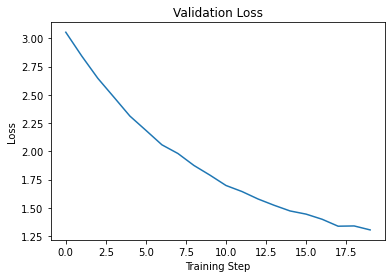

In [19]:
# Visualize loss curve

losses = history.history["val_loss"]
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.show()

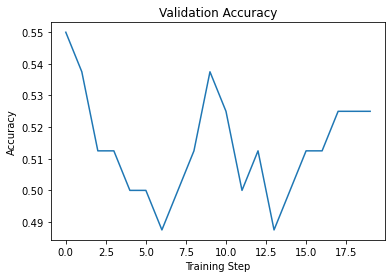

In [20]:
# Visualize accuracy curve

losses = history.history["val_accuracy"]
plt.plot(losses)
plt.xlabel("Training Step")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.show()

In [21]:
preds = model.predict(X_test_scaled)
preds = [1 if preds[i][0] >=0.5 else 0 for i in range(len(preds))]

tp = 0
fp = 0
fn = 0

for i in range(len(preds)):
    if preds[i] == 1 and y_test_final[i] == 1:
        tp += 1
    elif preds[i] == 1 and y_test_final[i] == 0:
        fp += 1
    elif preds[i] == 0 and y_test_final[i] == 1:
        fn += 1

prec = tp / (tp + fp)
rec = tp / (tp + fn)
f1 = (2 * prec * rec) / (prec + rec)

print (f'Precision: {prec}')
print (f'Recall: {rec}')
print (f'F1: {f1}')

4/4 [==============================] - 0s 6ms/step
Precision: 0.4
Recall: 0.4864864864864865
F1: 0.43902439024390244


In [22]:
print (classification_report(y_test_final, preds))

              precision    recall  f1-score   support

           0       0.65      0.57      0.61        63
           1       0.40      0.49      0.44        37

    accuracy                           0.54       100
   macro avg       0.53      0.53      0.52       100
weighted avg       0.56      0.54      0.55       100



## K-fold Cross-Validation

In [23]:
# Initialize kf
num_folds = 5
kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Train
acc_per_fold = []
loss_per_fold = []

fold_no = 1
for train, val in kf.split(X_train_resampled, y_train_resampled):
    model = create_model()
    
    history = model.fit(X_train_resampled[train], 
                        y_train_resampled[train], 
                        epochs=15, 
                        batch_size=32, 
                        validation_data=(X_train_resampled[val], y_train_resampled[val]))
    
    # Generate generalization metrics
    scores = model.evaluate(X_test_scaled, y_test_final, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no += 1

# Print average metrics
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/15
 4/10 [===========>..................] - ETA: 0s - loss: 3.2415 - accuracy: 0.5703

/Users/johngalvin/miniforge3/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/Users/johngalvin/miniforge3/lib/python3.9/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 [==============================] - 0s 28ms/step - loss: 3.2329 - accuracy: 0.5493 - val_loss: 3.0797 - val_accuracy: 0.6316
Epoch 2/15
10/10 [==============================] - 0s 25ms/step - loss: 2.9237 - accuracy: 0.7204 - val_loss: 2.9791 - val_accuracy: 0.6184
Epoch 3/15
10/10 [==============================] - 0s 27ms/step - loss: 2.7085 - accuracy: 0.8158 - val_loss: 2.8558 - val_accuracy: 0.6447
Epoch 4/15
10/10 [==============================] - 0s 25ms/step - loss: 2.5460 - accuracy: 0.8487 - val_loss: 2.7362 - val_accuracy: 0.6579
Epoch 5/15
10/10 [==============================] - 0s 25ms/step - loss: 2.3949 - accuracy: 0.8651 - val_loss: 2.6266 - val_accuracy: 0.6711
Epoch 6/15
10/10 [==============================] - 0s 25ms/step - loss: 2.2435 - accuracy: 0.9211 - val_loss: 2.5263 - val_accuracy: 0.6579
Epoch 7/15
10/10 [==============================] - 0s 25ms/step - loss: 2.1099 - accuracy: 0.9408 - val_loss: 2.4476 - val_accuracy: 0.6579
Epoch 8/15
10/10 [======

# XGBoost

In [14]:
import xgboost as xgb

In [15]:
model = xgb.XGBClassifier(tree_method="hist", enable_categorical=True)
model.fit(X_train_resampled, y_train_resampled)

In [17]:
y_pred = model.predict(X_test_scaled)

In [18]:
print(classification_report(y_test_final, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85        66
           1       0.76      0.56      0.64        34

    accuracy                           0.79       100
   macro avg       0.78      0.73      0.75       100
weighted avg       0.79      0.79      0.78       100



In [20]:
features = X.columns.to_list()
importance = list(model.feature_importances_)

In [21]:
feature_importance = dict(zip(features, importance))
feature_importance_df = pd.DataFrame.from_dict(feature_importance, orient='index').reset_index()
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df.sort_values('Importance', ascending=False)

,Feature,Importance
0,Diagnosis_at_Baseline,0.118102
95,travel.depth..SD.2016,0.056093
91,FreeSurfer.convexity..75..1024,0.044084
21,geodesic.depth..median.1024,0.029482
144,geodesic.depth..kurtosis.1034,0.025851
...,...,...
5,Race,0.000000
108,mean.curvature..median.1005,0.000000
4,Ethnicity,0.000000
116,geodesic.depth..25..1005,0.000000


# SVC Multimodal

Run all PCA cells and Merging cells, then these

In [24]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [25]:
# Instantiate Model
svc = SVC()

# Grid search
param_grid = {
    "C": [0.1, 1, 10],                
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto", 0.1],
    "degree": [1, 2, 3, 4, 5]}

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'degree': [1, 2, 3, 4, 5],
                         'gamma': ['scale', 'auto', 0.1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [26]:
# Get the best parameters and best accuracy score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

Best Parameters: {'C': 1, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best Accuracy: 0.7789473684210526


In [27]:
# Instantiate and fit model
svc = SVC(C=1, degree=1, gamma=0.1, kernel="rbf")

svc.fit(X_train_resampled, y_train_resampled)

SVC(C=1, degree=1, gamma=0.1)

In [28]:
# Assess
y_pred = svc.predict(X_test_scaled)

# evaluate predictions
print(classification_report(y_test_final, y_pred))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        63
           1       0.00      0.00      0.00        37

    accuracy                           0.63       100
   macro avg       0.32      0.50      0.39       100
weighted avg       0.40      0.63      0.49       100



/Users/johngalvin/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johngalvin/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johngalvin/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# SVC, Image-only

Run all PCA cells AND NN Image-only cells, then these

In [24]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [25]:
# Instantiate Model
svc = SVC()

# Grid search
param_grid = {
    "C": [0.1, 1, 10],                
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto", 0.1],
    "degree": [1, 2, 3, 4, 5]}

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'degree': [1, 2, 3, 4, 5],
                         'gamma': ['scale', 'auto', 0.1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [26]:
# Get the best parameters and best accuracy score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

Best Parameters: {'C': 1, 'degree': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best Accuracy: 0.7789473684210526


In [27]:
# Instantiate and fit model
svc = SVC(C=1, degree=1, gamma=0.1, kernel="rbf")

svc.fit(X_train_resampled, y_train_resampled)

SVC(C=1, degree=1, gamma=0.1)

In [28]:
# Assess
y_pred = svc.predict(X_test_scaled)

# evaluate predictions
print(classification_report(y_test_final, y_pred))

              precision    recall  f1-score   support

           0       0.63      1.00      0.77        63
           1       0.00      0.00      0.00        37

    accuracy                           0.63       100
   macro avg       0.32      0.50      0.39       100
weighted avg       0.40      0.63      0.49       100



/Users/johngalvin/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johngalvin/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/johngalvin/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# RFC, Multimodal

Run all PCA cells and Merging cells, then these

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [31]:
y_pred = rfc.predict(X_test_scaled)

In [32]:
# Calculate accuracy
accuracy = accuracy_score(y_test_final, y_pred)
print("Accuracy:", accuracy)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test_final, y_pred))

Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84        63
           1       0.78      0.57      0.66        37

    accuracy                           0.78       100
   macro avg       0.78      0.74      0.75       100
weighted avg       0.78      0.78      0.77       100



# RFC, Image-only

Run all PCA cells and NN image-only cells, then these

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [31]:
y_pred = rfc.predict(X_test_scaled)

In [32]:
# Calculate accuracy
accuracy = accuracy_score(y_test_final, y_pred)
print("Accuracy:", accuracy)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test_final, y_pred))

Accuracy: 0.64
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.74        63
           1       0.52      0.38      0.44        37

    accuracy                           0.64       100
   macro avg       0.60      0.59      0.59       100
weighted avg       0.62      0.64      0.63       100



# Inference

In [41]:
import joblib
import numpy as np

In [ ]:
json_obj = {"Diagnosis_at_Baseline":"LMCI","Age":67.5,"Gender":"Male","Years_of_Education":10,"Ethnicity":"Hisp/Latino","Race":"White","APOE4":0.0,"MMSE":27.0,"FreeSurfer.convexity..median.1024":-0.3041386604,"FreeSurfer.convexity..75..1005":-0.0419929773,"FreeSurfer.convexity..25..2017":-0.8225753903,"geodesic.depth..median.1017":0.0739987,"FreeSurfer.convexity..75..1013":0.0415118048,"FreeSurfer.convexity..mean.1005":-0.3293391367,"FreeSurfer.convexity..SD.2016":0.3947719923,"mean.curvature..skew.2007":-0.7409500265,"travel.depth..kurtosis.2016":-0.9291294844,"geodesic.depth..kurtosis.2016":-0.8025531133,"FreeSurfer.convexity..skew.1005":-0.2868374242,"geodesic.depth..MAD.1017":0.07025852,"geodesic.depth..kurtosis.2003":-1.0512882688,"geodesic.depth..median.1024":0.130673,"FreeSurfer.thickness..kurtosis.2031":-0.4094972527,"geodesic.depth..25..1024":0.0283946,"FreeSurfer.convexity..median.1005":-0.4463556409,"FreeSurfer.convexity..mean.1024":-0.1882189398,"FreeSurfer.convexity..kurtosis.1035":-1.0478155295,"travel.depth..median.1017":2.50808,"FreeSurfer.convexity..MAD.1034":0.3352779895,"FreeSurfer.convexity..mean.1013":-0.2379040985,"FreeSurfer.convexity..mean.2017":-0.3073992311,"mean.curvature..kurtosis.1012":-0.3161156595,"travel.depth..25..2014":0.18153,"FreeSurfer.thickness..MAD.1030":0.4815375805,"FreeSurfer.convexity..SD.2007":0.455420991,"geodesic.depth..skew.1005":0.244972332,"FreeSurfer.convexity..mean.1017":-0.2939803651,"travel.depth..MAD.1017":2.387827,"geodesic.depth..75..1013":0.143296,"FreeSurfer.convexity..median.2017":-0.4740116894,"mean.curvature..kurtosis.2017":-0.521346065,"travel.depth..skew.1005":0.3099299457,"geodesic.depth..mean.1024":0.1632739171,"geodesic.depth..mean.1017":0.1118046319,"FreeSurfer.thickness..SD.1030":0.7515073666,"FreeSurfer.thickness..kurtosis.2011":-0.1043461037,"FreeSurfer.convexity..kurtosis.2003":-0.9081563766,"geodesic.depth..75..1035":0.857783,"FreeSurfer.convexity..median.1017":-0.3944549263,"FreeSurfer.convexity..75..1017":0.0557703637,"FreeSurfer.convexity..median.1013":-0.3122470379,"FreeSurfer.convexity..kurtosis.2016":-0.6604310251,"geodesic.depth..75..1024":0.259387,"travel.depth..25..1017":0.382777,"FreeSurfer.thickness..skew.1007":0.8298158569,"travel.depth..kurtosis.2003":-1.0165734317,"FreeSurfer.convexity..kurtosis.2030":-1.0448463437,"FreeSurfer.convexity..kurtosis.1005":-1.0601843929,"geodesic.depth..median.1013":0.0703935,"geodesic.depth..75..1034":0.713412,"geodesic.depth..kurtosis.2009":-1.182161277,"geodesic.depth..75..1017":0.18889,"FreeSurfer.thickness..median.1017":1.7823790312,"travel.depth..25..1024":0.839302,"geodesic.depth..kurtosis.1009":-1.1346834489,"FreeSurfer.thickness..kurtosis.2017":0.3652512457,"mean.curvature..kurtosis.2012":-0.160233786,"FreeSurfer.convexity..SD.1034":0.4434771189,"FreeSurfer.convexity..MAD.2016":0.2350733727,"mean.curvature..skew.2029":-0.607839259,"geodesic.depth..mean.1013":0.0943134866,"FreeSurfer.thickness..MAD.2021":0.1749446392,"FreeSurfer.convexity..75..2034":0.7047955394,"FreeSurfer.convexity..SD.2003":0.6360757545,"mean.curvature..kurtosis.2007":-0.5114699725,"FreeSurfer.thickness..kurtosis.2021":0.147405259,"geodesic.depth..SD.2012":0.1262609047,"FreeSurfer.convexity..median.2012":-0.0724348575,"FreeSurfer.thickness..kurtosis.2025":-0.1472087948,"geodesic.depth..25..2014":0.00352458,"geodesic.depth..median.1034":0.584828,"FreeSurfer.thickness..MAD.2031":0.3680799007,"travel.depth..skew.2002":0.358924359,"geodesic.depth..kurtosis.1018":-1.0160986685,"FreeSurfer.convexity..25..1005":-0.6565053463,"FreeSurfer.convexity..25..1024":-0.663970992,"travel.depth..kurtosis.2002":-0.0268656742,"FreeSurfer.convexity..75..2022":0.1616883576,"FreeSurfer.convexity..25..2012":-0.3725186884,"travel.depth..kurtosis.1005":-0.9440314871,"mean.curvature..SD.2009":2.8947270611,"FreeSurfer.convexity..75..1024":0.2195511907,"FreeSurfer.convexity..SD.2017":0.6740049304,"travel.depth..MAD.1022":4.342545,"FreeSurfer.convexity..MAD.2003":0.4325919598,"travel.depth..SD.2016":3.3096376094,"mean.curvature..25..1024":-4.90336,"geodesic.depth..25..1017":0.0228513,"geodesic.depth..25..2030":0.0561638,"FreeSurfer.convexity..MAD.1035":0.3746078629,"geodesic.depth..SD.2034":0.118692501,"FreeSurfer.thickness..75..1017":2.0929532051,"mean.curvature..kurtosis.1024":-0.5876524549,"FreeSurfer.thickness..25..2013":1.4965190887,"mean.curvature..kurtosis.2011":-0.5208675406,"FreeSurfer.convexity..mean.2012":-0.0691443482,"travel.depth..kurtosis.2034":-0.8980741063,"FreeSurfer.thickness..median.2017":1.8157212734,"mean.curvature..median.1005":-3.0374,"FreeSurfer.thickness..25..2025":1.7547264099,"geodesic.depth..kurtosis.1005":-0.9931310138,"FreeSurfer.convexity..75..2016":0.0944628343,"FreeSurfer.thickness..median.2013":1.8782224655,"geodesic.depth..MAD.1013":0.0536722,"FreeSurfer.thickness..mean.1017":1.8336383661,"FreeSurfer.thickness..skew.1017":0.600432719,"geodesic.depth..25..1005":0.0231425,"FreeSurfer.thickness..MAD.2016":0.6036396027,"travel.depth..25..2022":0.614581,"geodesic.depth..SD.2016":0.0760734152,"FreeSurfer.thickness..SD.2016":0.8008621442,"geodesic.depth..mean.2012":0.1578962955,"geodesic.depth..median.2030":0.167719,"FreeSurfer.convexity..skew.2014":-0.4254214236,"FreeSurfer.convexity..SD.2031":0.6303603764,"geodesic.depth..MAD.1030":0.11987,"travel.depth..kurtosis.1034":-0.8440365362,"travel.depth..25..1005":0.516824,"travel.depth..skew.2030":-0.1790890009,"FreeSurfer.thickness..25..2017":1.5213327408,"FreeSurfer.convexity..MAD.2017":0.3930668533,"geodesic.depth..25..1013":0.0246371,"geodesic.depth..mean.1034":0.5689924216,"geodesic.depth..skew.2029":0.1788553668,"travel.depth..25..2030":2.03181,"mean.curvature..mean.1005":-2.884279856,"FreeSurfer.convexity..MAD.2022":0.4344983399,"FreeSurfer.convexity..kurtosis.2031":-0.6973119537,"mean.curvature..skew.2014":-0.8078628207,"geodesic.depth..75..1030":0.294473,"FreeSurfer.convexity..skew.1012":-0.5357308943,"mean.curvature..75..2025":-0.457938,"FreeSurfer.thickness..kurtosis.1017":0.0504272664,"travel.depth..25..2031":1.21267,"geodesic.depth..kurtosis.1034":-0.850155529,"geodesic.depth..kurtosis.2002":-0.8246946132,"mean.curvature..75..1013":-1.37892,"FreeSurfer.thickness..25..1017":1.5172727108,"geodesic.depth..mean.1030":0.188601711,"travel.depth..SD.2034":5.3649734516,"geodesic.depth..skew.2030":-0.1685252461,"FreeSurfer.thickness..kurtosis.2029":0.1881543029,"travel.depth..SD.2012":5.2739536048,"geodesic.depth..median.2014":0.0377215,"FreeSurfer.thickness..75..2013":2.3669848442,"travel.depth..75..1013":5.4461825,"FreeSurfer.convexity..kurtosis.2017":-1.2241311804,"geodesic.depth..SD.1030":0.1821043959}

In [ ]:
dx_encoder = joblib.load("./dx_encoder.gz")
gender_encoder = joblib.load("gender_encoder.gz")
eth_encoder = joblib.load("eth_encoder.gz")
race_encoder = joblib.load("race_encoder.gz")

In [ ]:
json_obj["Diagnosis_at_Baseline"] = dx_encoder.transform([json_obj["Diagnosis_at_Baseline"]])[0]
json_obj["Gender"] = gender_encoder.transform([json_obj["Gender"]])[0]
json_obj["Ethnicity"] = eth_encoder.transform([json_obj["Ethnicity"]])[0]
json_obj["Race"] = race_encoder.transform([json_obj["Race"]])[0]

In [ ]:
scaler = joblib.load("./scaler.gz")
feature_array = np.array(list(json_obj.values())).reshape(1,-1)
features_scaled = scaler.transform(feature_array)

In [ ]:
model = joblib.load("model.pkl")

In [ ]:
model.predict(features_scaled)